# Imports

In [1]:
from dqn.dqn import QNetwork, ReplayMemory
from policies.eps_greedy import EpsilonGreedyPolicy
from train_eval.train import train

import random
import numpy as np
import torch
from torch import optim
import gym
import matplotlib.pyplot as plt

# Load the environment

In [2]:
env = gym.envs.make("CartPole-v1")

C:\Users\kylia\Anaconda3\envs\rl2020\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Create DQN and policy

In [3]:
seed = 1  # This is not randomly chosen
num_hidden = 128
eps = 0.05

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden=num_hidden)
policy = EpsilonGreedyPolicy(Q_net, eps)

# Function to run episodes and call training function (with replay memory)

In [4]:
def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []
    state_values = []
    init_state = env.reset()
    for i in range(num_episodes):
        state = env.reset()

        steps = 0
        while True:
            # Set epsilon according to number of steps
            policy.set_epsilon(global_steps)
            # Sample an action, next state, reward and done
            a = policy.sample_action(state)
            s_next, r, done, _ = env.step(a)
            # Add the transition to the memory buffer
            memory.push((state, a, r, s_next, done))
            # Perform training on the buffer
            loss = train(Q, memory, optimizer, batch_size, discount_factor)
            # Increase step counts and set current state
            steps += 1
            global_steps += 1
            state = s_next
            
            if global_steps % 100 == 0:
                with torch.no_grad():
                    Q.eval()
                    Q_vals = Q(torch.Tensor([init_state]))
                    maxx, _ = torch.max(Q_vals, dim=1)
                    state_values.append(maxx)

            if done:
                if i % 10 == 0:
                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                break
    return episode_durations, state_values

# Perform training

In [5]:
num_episodes = 1000
batch_size = 10
discount_factor = 0.9
learn_rate = 1e-3
# To switch off Replay Memory mechanism, simply set size to batch size
memory = ReplayMemory(10000)

optimizer = optim.Adam(Q_net.parameters(), learn_rate)
episode_durations, state_values = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer)

 Episode 0 finished after 23 steps
 Episode 10 finished after 14 steps
 Episode 20 finished after 10 steps
 Episode 30 finished after 13 steps
 Episode 40 finished after 10 steps
 Episode 50 finished after 9 steps
 Episode 60 finished after 10 steps
 Episode 70 finished after 10 steps
 Episode 80 finished after 9 steps
 Episode 90 finished after 12 steps
 Episode 100 finished after 10 steps
 Episode 110 finished after 10 steps
 Episode 120 finished after 9 steps
 Episode 130 finished after 10 steps
 Episode 140 finished after 10 steps
 Episode 150 finished after 10 steps
 Episode 160 finished after 10 steps
 Episode 170 finished after 10 steps
 Episode 180 finished after 10 steps
 Episode 190 finished after 10 steps
 Episode 200 finished after 10 steps
 Episode 210 finished after 11 steps
 Episode 220 finished after 10 steps
 Episode 230 finished after 10 steps
 Episode 240 finished after 9 steps
 Episode 250 finished after 9 steps
 Episode 260 finished after 10 steps
 Episode 270 fini

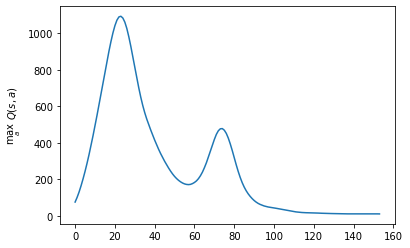

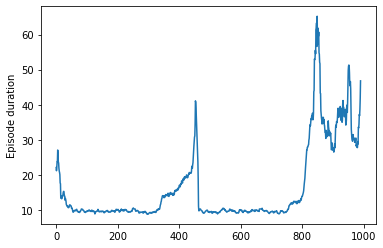

In [6]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(np.array(state_values), 10))
plt.ylabel('$\max_a\ Q(s,a)$')
plt.show()

plt.plot(smooth(np.array(episode_durations), 10))
plt.ylabel('Episode duration')
plt.show()

# Function to run episodes and call training function (without replay memory)

In [7]:
def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    state_values = []
    init_state = env.reset()
    for i in range(num_episodes):
        state = env.reset()

        steps = 0
        while True:
            # Set epsilon according to number of steps
            policy.set_epsilon(global_steps)
            # Increase step counts
            steps += 1
            global_steps += 1
            # Sample an action, next state, reward and done
            a = policy.sample_action(state)
            s_next, r, done, _ = env.step(a)
            # Add the transition to the memory buffer
            memory.push((state, a, r, s_next, done))
            # Perform training on the buffer
            if global_steps % batch_size == 0:
                loss = train(Q, memory, optimizer, batch_size, discount_factor)
            state = s_next
            
            if global_steps % 100 == 0:
                with torch.no_grad():
                    Q.eval()
                    Q_vals = Q(torch.Tensor([init_state]))
                    maxx, _ = torch.max(Q_vals, dim=1)
                    state_values.append(maxx)

            if done:
                if i % 100 == 0:
                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                break
    return episode_durations, state_values

In [8]:
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden=num_hidden)
policy = EpsilonGreedyPolicy(Q_net, eps)

num_episodes = 10000
batch_size = 1
discount_factor = 0.9
learn_rate = 1e-3
memory = ReplayMemory(batch_size)

optimizer = optim.Adam(Q_net.parameters(), learn_rate)
episode_durations, state_values = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer)

 Episode 0 finished after 25 steps
 Episode 100 finished after 10 steps
 Episode 200 finished after 44 steps
 Episode 300 finished after 69 steps
 Episode 400 finished after 185 steps
 Episode 500 finished after 133 steps
 Episode 600 finished after 414 steps
 Episode 700 finished after 500 steps
 Episode 800 finished after 27 steps
 Episode 900 finished after 15 steps
 Episode 1000 finished after 19 steps
 Episode 1100 finished after 236 steps
 Episode 1200 finished after 179 steps
 Episode 1300 finished after 13 steps
 Episode 1400 finished after 122 steps
 Episode 1500 finished after 500 steps
 Episode 1600 finished after 16 steps
 Episode 1700 finished after 108 steps
 Episode 1800 finished after 22 steps
 Episode 1900 finished after 231 steps
 Episode 2000 finished after 136 steps
 Episode 2100 finished after 147 steps
 Episode 2200 finished after 16 steps
 Episode 2300 finished after 64 steps
 Episode 2400 finished after 62 steps
 Episode 2500 finished after 500 steps
 Episode 26

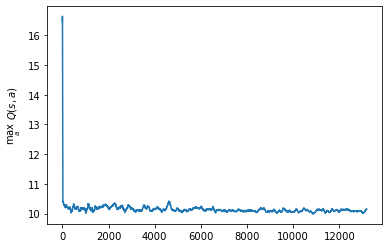

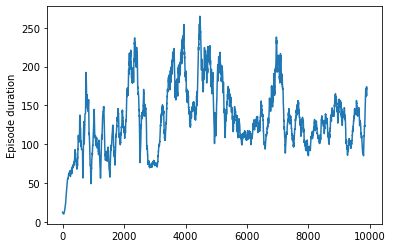

In [9]:
plt.plot(smooth(np.array(state_values), 100))
plt.ylabel('$\max_a\ Q(s,a)$')
plt.show()

plt.plot(smooth(np.array(episode_durations), 100))
plt.ylabel('Episode duration')
plt.show()